---
title: scgpt quickstart - jupyter notebook
freeze: true
eval: false
author: Haky Im based on cziscience page
date: 2025-05-13
categories: 
    - notebook
    - gene46100
---

https://virtualcellmodels.cziscience.com/quickstart/scgpt-quickstart

## Quick Start: scGPT

This quick start will guide you through using the scGPT model, trained on 33 million cells (including data from the CZ CELLxGENE Census), to generate embeddings for single-cell transcriptomic data analysis.
Learning Goals

By the end of this tutorial, you will understand how to:

    Access and prepare the scGPT model for use.
    Generate embeddings to analyze and compare your dataset against the CZ CELLxGENE Census.
    Visualize the results using a UMAP, colored by cell type.

### Pre-requisites and Requirements

Before starting, ensure you are familiar with:

    Python and AnnData
    Single-cell data analysis (see this tutorial for a primer on the subject) You can run this tutorial locally (tested on an M3 MacBook with 32 GiB memory) or in Google Colab using a T4 instance. Environment setup will be covered in a later section.

### Overview

This notebook provides a step-by-step guide to:

    Setting up your environment
    Downloading the necessary model checkpoints and h5ad dataset
    Performing model inference to create embeddings
    Visualizing the results with UMAP


### Setup

Let's start by setting up dependencies. The released version of scGPT requires PyTorch 2.1.2, so we will remove the existing PyTorch installation and replace it with the required one. If you want to run this on another environment, this step might not be necessary.

** but then I got error about torch version. So I installed torch 2.3.0 and torchvision 0.16.2. and then reinstalled torch 2.1.2.**


```{{bash}}
conda create -n scgpt python=3.9
conda activate scgpt
```

In [1]:
first_time = False
if first_time:
    # First uninstall the conflicting packages
    %pip uninstall -y -q torch torchvision
    %pip uninstall -y numpy pandas scipy scikit-learn anndata cell-gears datasets dcor
    #%pip install -q torchvision==0.16.2 torch==2.1.2
    %pip install -q torch==2.3.0 torchvision==0.16.2
    %pip install -q scgpt scanpy gdown


    # Then install them in the correct order with specific versions
    %pip install numpy==1.23.5
    %pip install pandas==1.5.3  # This version is compatible with anndata 0.10.9
    %pip install scipy==1.10.1  # This version is >1.8 as required by anndata
    %pip install scikit-learn==1.2.2
    %pip install anndata==0.10.9
    %pip install cell-gears==0.0.2
    %pip install dcor==0.6

    %pip install datasets==2.3.0


    # First uninstall both packages
    %pip uninstall -y torch torchtext

    # Then install compatible versions
    %pip install torch==2.1.2 torchtext==0.16.2

We can install the rest of our dependencies and import the relevant libraries.

In [2]:
# Import libraries

# Import required packages
import os
import multiprocessing

# Set MPS fallback for unimplemented operations
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Monkey-patch os.sched_getaffinity for macOS
if not hasattr(os, 'sched_getaffinity'):
    def sched_getaffinity(pid):
        return set(range(multiprocessing.cpu_count()))
    os.sched_getaffinity = sched_getaffinity

import warnings
import urllib.request
from pathlib import Path

import scgpt as scg
import scanpy as sc
import numpy as np
import pandas as pd
import torch

# Check for MPS availability
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")
print("Note: Some operations may fall back to CPU due to MPS limitations")

warnings.filterwarnings("ignore")

/Users/haekyungim/miniconda3/envs/scgpt/lib/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/Users/haekyungim/miniconda3/envs/scgpt/lib/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/Users/haekyungim/miniconda3/envs/scgpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Note: Some operations may fall back to CPU due to MPS limitations


In [3]:
# Define the base working directory
WORKDIR = "/Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/scgpt"
# Convert to Path objects for better path handling
WORKDIR = Path(WORKDIR)
DATA_DIR = WORKDIR / "data"
MODEL_DIR = WORKDIR / "model" 

Download Model Checkpoints and Data

Let's download the checkpoints from the scGPT repository.

In [4]:
warnings.simplefilter("ignore", ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

# Use gdown with the recursive flag to download the folder
# Replace the folder ID with the ID of your folder
folder_id = '1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y'

# Check if model files already exist
if not (MODEL_DIR / "args.json").exists():
    print("Downloading model checkpoint...")
    !gdown --folder {folder_id} -O {MODEL_DIR}
else:
    print("Model files already exist in", MODEL_DIR)

Model files already exist in /Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/scgpt/model


We will now download an H5AD dataset from CZ CELLxGENE. To reduce memory utilization, we will also perform a reduction to the top 3000 highly variable genes using scanpy's highly_variable_genes function.

In [5]:
uri = "https://datasets.cellxgene.cziscience.com/f50deffa-43ae-4f12-85ed-33e45040a1fa.h5ad"
source_path = DATA_DIR / "source.h5ad"

# Check if file exists before downloading
if not source_path.exists():
    print(f"Downloading dataset to {source_path}...")
    urllib.request.urlretrieve(uri, filename=str(source_path))
else:
    print(f"Dataset already exists at {source_path}")

# Read the data
adata = sc.read_h5ad(source_path)

batch_key = "sample"
N_HVG = 3000

sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata_hvg = adata[:, adata.var['highly_variable']]

Dataset already exists at /Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/scgpt/data/source.h5ad


We can now use embed_data to generate the embeddings. Note that gene_col needs to point to the column where the gene names (not symbols!) are defined. For CZ CELLxGENE datasets, they are stored in the feature_name column.

In [6]:
# Monkey patch get_batch_cell_embeddings to force single processor
import types
from scgpt.tasks.cell_emb import get_batch_cell_embeddings as original_get_batch_cell_embeddings
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from scgpt.data_collator import DataCollator
import numpy as np
from tqdm import tqdm

# Define Dataset class at module level
class CellEmbeddingDataset(Dataset):
    def __init__(self, count_matrix, gene_ids, batch_ids=None, vocab=None, model_configs=None):
        self.count_matrix = count_matrix
        self.gene_ids = gene_ids
        self.batch_ids = batch_ids
        self.vocab = vocab
        self.model_configs = model_configs

    def __len__(self):
        return len(self.count_matrix)

    def __getitem__(self, idx):
        row = self.count_matrix[idx]
        nonzero_idx = np.nonzero(row)[0]
        values = row[nonzero_idx]
        genes = self.gene_ids[nonzero_idx]
        # append <cls> token at the beginning
        genes = np.insert(genes, 0, self.vocab["<cls>"])
        values = np.insert(values, 0, self.model_configs["pad_value"])
        genes = torch.from_numpy(genes).long()
        values = torch.from_numpy(values).float()
        output = {
            "id": idx,
            "genes": genes,
            "expressions": values,
        }
        if self.batch_ids is not None:
            output["batch_labels"] = self.batch_ids[idx]
        return output

def patched_get_batch_cell_embeddings(
    adata,
    cell_embedding_mode: str = "cls",
    model=None,
    vocab=None,
    max_length=1200,
    batch_size=64,
    model_configs=None,
    gene_ids=None,
    use_batch_labels=False,
) -> np.ndarray:
    """
    Patched version of get_batch_cell_embeddings that uses the module-level Dataset class
    and forces num_workers=0.
    """
    count_matrix = adata.X
    count_matrix = (
        count_matrix if isinstance(count_matrix, np.ndarray) else count_matrix.toarray()
    )

    # gene vocabulary ids
    if gene_ids is None:
        gene_ids = np.array(adata.var["id_in_vocab"])
        assert np.all(gene_ids >= 0)

    if use_batch_labels:
        batch_ids = np.array(adata.obs["batch_id"].tolist())

    if cell_embedding_mode == "cls":
        dataset = CellEmbeddingDataset(
            count_matrix, 
            gene_ids, 
            batch_ids if use_batch_labels else None,
            vocab=vocab,
            model_configs=model_configs
        )
        collator = DataCollator(
            do_padding=True,
            pad_token_id=vocab[model_configs["pad_token"]],
            pad_value=model_configs["pad_value"],
            do_mlm=False,
            do_binning=True,
            max_length=max_length,
            sampling=True,
            keep_first_n_tokens=1,
        )
        data_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SequentialSampler(dataset),
            collate_fn=collator,
            drop_last=False,
            num_workers=0,  # Force single worker
            pin_memory=True,
        )

        # Use the global device variable instead of getting it from model
        cell_embeddings = np.zeros(
            (len(dataset), model_configs["embsize"]), dtype=np.float32
        )
        with torch.no_grad():
            # Disable autocast for MPS as it's not supported
            count = 0
            for data_dict in tqdm(data_loader, desc="Embedding cells"):
                input_gene_ids = data_dict["gene"].to(device)
                src_key_padding_mask = input_gene_ids.eq(
                    vocab[model_configs["pad_token"]]
                )
                embeddings = model._encode(
                    input_gene_ids,
                    data_dict["expr"].to(device),
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=data_dict["batch_labels"].to(device)
                    if use_batch_labels
                    else None,
                )

                embeddings = embeddings[:, 0, :]  # get the <cls> position embedding
                embeddings = embeddings.cpu().numpy()
                cell_embeddings[count : count + len(embeddings)] = embeddings
                count += len(embeddings)
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
    else:
        raise ValueError(f"Unknown cell embedding mode: {cell_embedding_mode}")
    return cell_embeddings

# Replace the original function with our patched version
import scgpt.tasks.cell_emb
scgpt.tasks.cell_emb.get_batch_cell_embeddings = patched_get_batch_cell_embeddings

os.environ['PYTHONWARNINGS'] = 'ignore'

In [7]:
model_dir = MODEL_DIR #/ "scGPT_human"
gene_col = "feature_name"
cell_type_key = "cell_type"

embedding_file = DATA_DIR / "ref_embed_adata.h5ad"

if embedding_file.exists():
    print(f"Loading existing embeddings from {embedding_file}")
    ref_embed_adata = sc.read_h5ad(str(embedding_file))
else:
    print("Computing new embeddings...")
    ref_embed_adata = scg.tasks.embed_data(
        adata_hvg,
        model_dir,
        gene_col=gene_col,
        obs_to_save=cell_type_key,
        batch_size=64,
        return_new_adata=True,
        device=device,  # Pass the device to embed_data
    )
    print(f"Saving embeddings to {embedding_file}")
    ref_embed_adata.write(str(embedding_file))


Loading existing embeddings from /Users/haekyungim/Library/CloudStorage/Box-Box/LargeFiles/imlab-data/data-Github/web-data/web-GENE-46100/scgpt/data/ref_embed_adata.h5ad


Our scGPT embeddings are stored in the .X attribute of the returned AnnData object and have a dimensionality of 512.

In [8]:
ref_embed_adata.X.shape

(11103, 512)

We can now calculate neighbors based on scGPT embeddings.

In [9]:
sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)

We will put our calculated UMAP and embeddings in our original adata object with our original annotations.

In [10]:
adata.obsm["X_scgpt"] = ref_embed_adata.X
adata.obsm["X_umap"] = ref_embed_adata.obsm["X_umap"]

We can also switch our .var index which is currently set to Ensembl ID's, to be gene symbols, allowing us to plot gene expression more easily.

In [11]:
# Add the current index ('ensembl_id') as a new column
adata.var['ensembl_id'] = adata.var.index

# Set the new index to the 'feature_name' column
adata.var.set_index('feature_name', inplace=True)

In [12]:
# Add a copy of the gene symbols back to the var dataframe
adata.var['gene_symbol'] = adata.var.index

We can now plot a UMAP, coloring it by cell type to visualize our embeddings. Below, we color by both the standard cell type labels provided by CZ CELLxGENE and the original cell type annotations from the authors. The embeddings generated by scGPT effectively capture the structure of the data, closely aligning with the original author annotations.

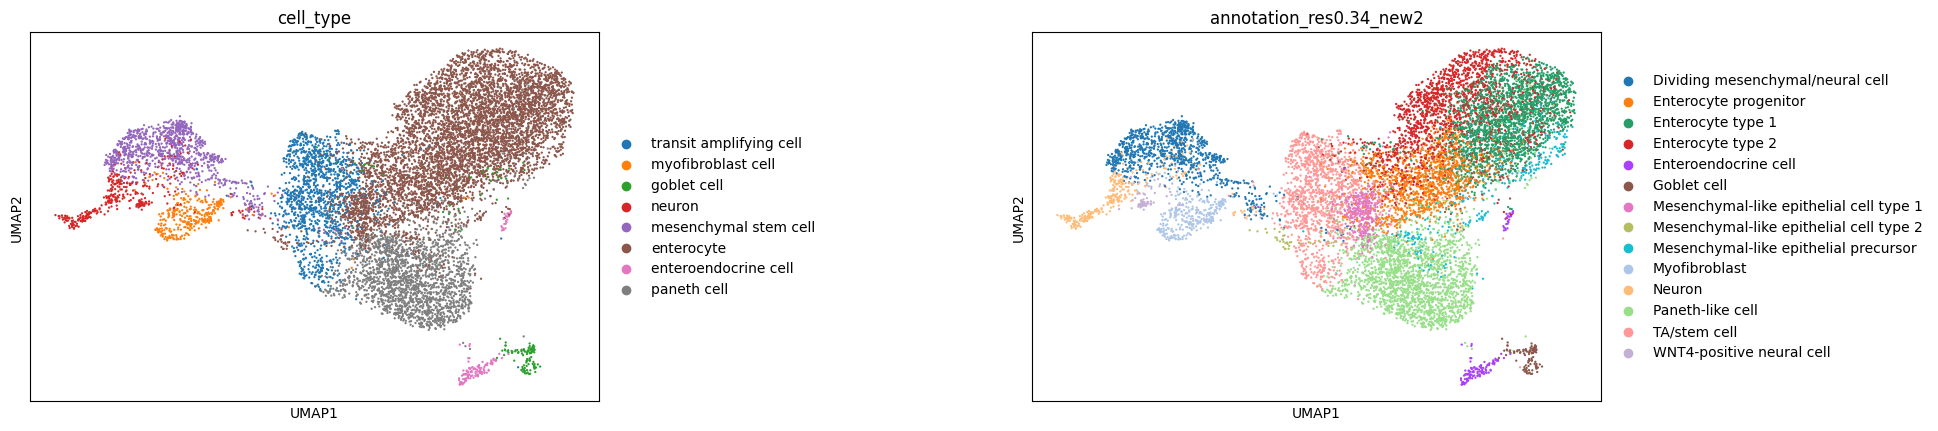

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #sc.pp.neighbors(ref_embed_adata, use_rep="X")
    #sc.tl.umap(ref_embed_adata)
    sc.pl.umap(adata, color=["cell_type", "annotation_res0.34_new2"], wspace = 0.6)

We can also take a look at some markers of the major cell types represented in the dataset.

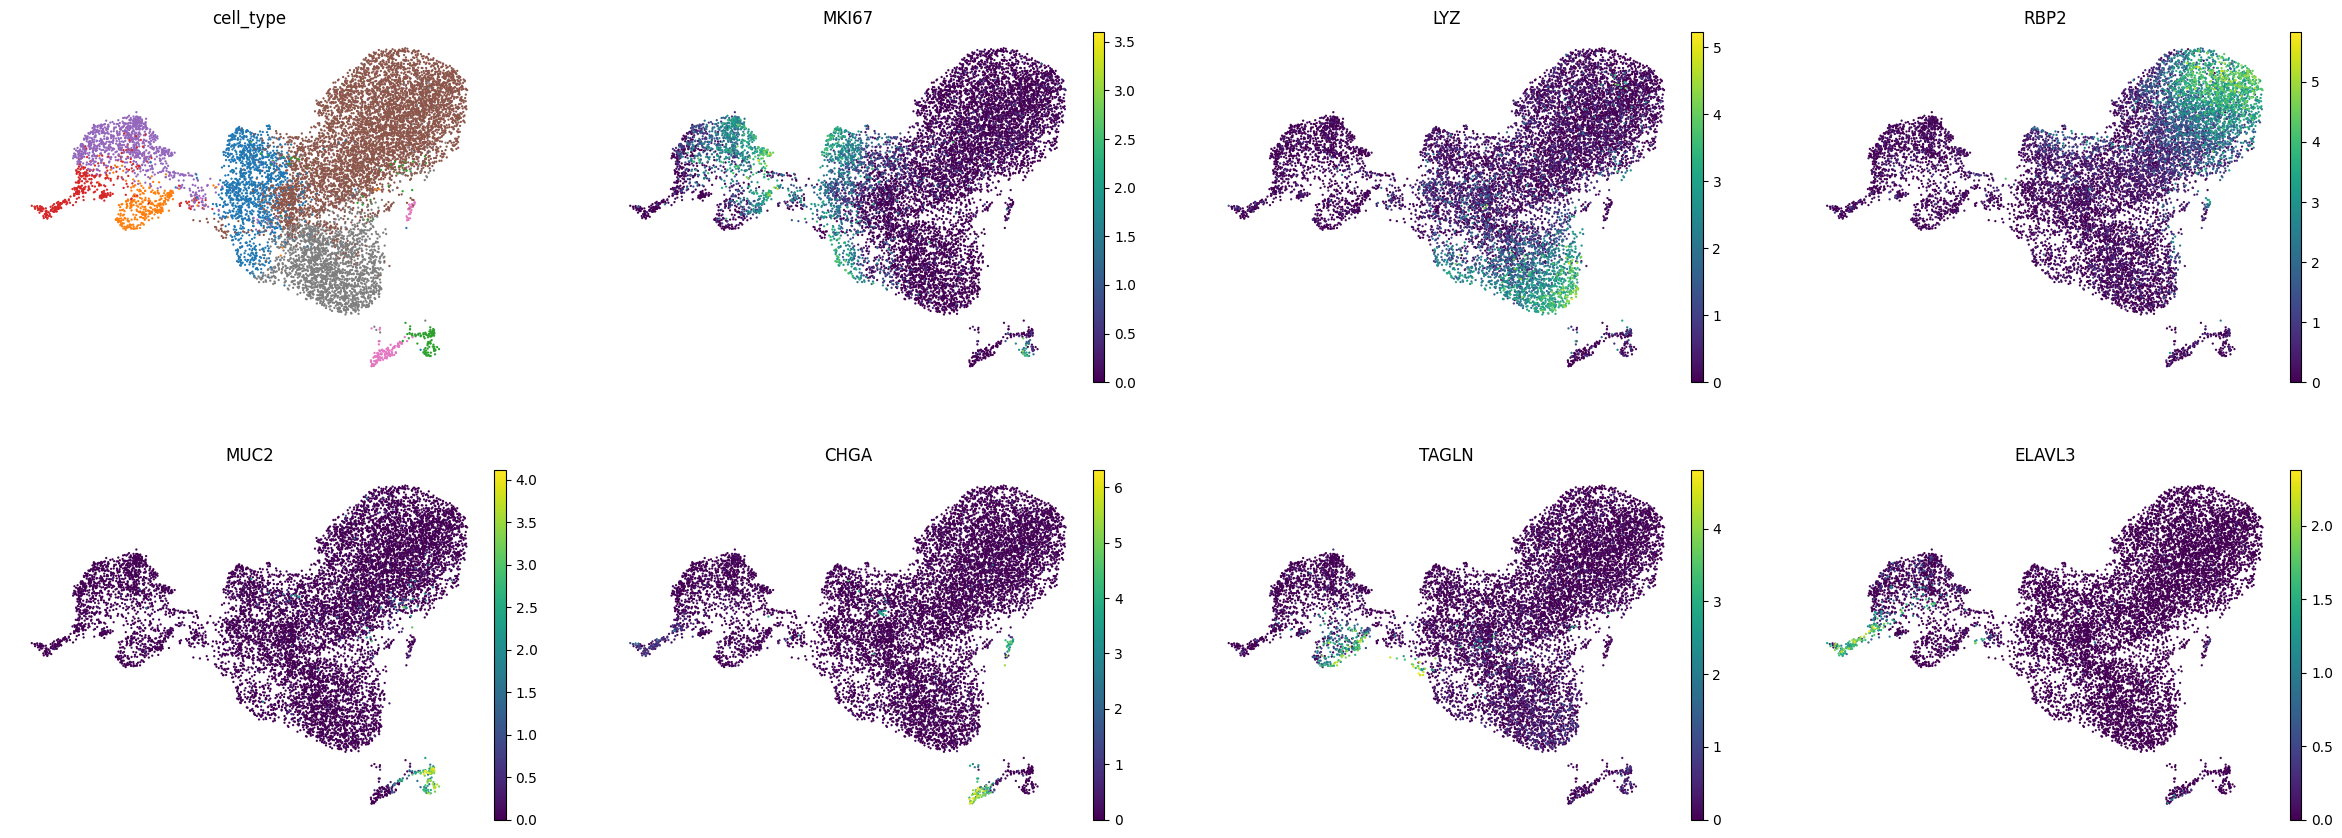

In [14]:
sc.pl.umap(adata, color=['cell_type', 'MKI67', 'LYZ', 'RBP2', 'MUC2', 'CHGA', 'TAGLN', 'ELAVL3'], frameon=False, use_raw=False, legend_fontsize ="xx-small", legend_loc="none")

References

Please refer to the following papers for information about:

scGPT: Toward building a foundation model for single-cell multi-omics using generative AI

Cui, H., Wang, C., Maan, H. et al. scGPT: toward building a foundation model for single-cell multi-omics using generative AI. Nat Methods 21, 1470–1480 (2024). https://doi.org/10.1038/s41592-024-02201-0

The dataset used in this tutorial

Moerkens, R., Mooiweer, J., Ramírez-Sánchez, A. D., Oelen, R., Franke, L., Wijmenga, C., Barrett, R. J., Jonkers, I. H., & Withoff, S. (2024). An iPSC-derived small intestine-on-chip with self-organizing epithelial, mesenchymal, and neural cells. Cell Reports, 43(7). https://doi.org/10.1016/j.celrep.2024.114247

CZ CELLxGENE Discover and Census

CZ CELLxGENE Discover: A single-cell data platform for scalable exploration, analysis and modeling of aggregated data CZI Single-Cell Biology, et al. bioRxiv 2023.10.30; doi: https://doi.org/10.1101/2023.10.30.563174
